## Importing Packages

In [3]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [4]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
#     w1 = 90000.0
#     w2 = 10000.0
#     w3 = 100000.0 
#     w4 = 200000.0
#     w5 = 300000.0
#     w6 = 400000.0
#     w7 = 500000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 1e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [5]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

Creating Markers...
  0.153160 seconds (154.32 k allocations: 41.612 MiB, 5.46% gc time, 92.27% compilation time)
Initial condition...
  0.170961 seconds (1.79 M allocations: 31.692 MiB, 48.72% compilation time: 25% of which was recompilation)
Trying with timestep 1.315261761795513e9 Seconds
Trying with timestep 8.386006753887646e7 Seconds
Writing visualization file = test/viz.0000.vtr
Writing visualization file = test/markers.0000.vtp
  0.003619 seconds (2 allocations: 5.493 MiB)
Finished Step 2 time=5.386157110128674e6 Seconds
Trying with timestep 6.463388532154408e6 Seconds
Trying with timestep 4.235697646941191e6 Seconds
Finished Step 3 time=8.194732540640198e6 Seconds
Trying with timestep 3.3702905166138294e6 Seconds
Finished Step 4 time=1.1565023057254028e7 Seconds
Trying with timestep 4.044348619936595e6 Seconds
Finished Step 5 time=1.5609371677190622e7 Seconds
Trying with timestep 4.853218343923914e6 Seconds
Finished Step 6 time=2.0462590021114536e7 Seconds
Trying with timestep

Trying with timestep 4.649235442628971e9 Seconds
Finished Step 79 time=1.2469523014442288e11 Seconds
Trying with timestep 4.80934687073558e9 Seconds
Finished Step 80 time=1.2950457701515846e11 Seconds
Trying with timestep 4.976914375782022e9 Seconds
Finished Step 81 time=1.3448149139094049e11 Seconds
Trying with timestep 5.142514059447507e9 Seconds
Finished Step 82 time=1.39624005450388e11 Seconds
Trying with timestep 5.313269678899015e9 Seconds
Finished Step 83 time=1.4493727512928702e11 Seconds
Trying with timestep 5.4908805256641245e9 Seconds
Finished Step 84 time=1.5042815565495114e11 Seconds
Trying with timestep 5.659699115384431e9 Seconds
Finished Step 85 time=1.5608785477033557e11 Seconds
Trying with timestep 5.849245523105554e9 Seconds
Finished Step 86 time=1.6193710029344113e11 Seconds
Trying with timestep 6.037332596637663e9 Seconds
Finished Step 87 time=1.679744328900788e11 Seconds
Trying with timestep 6.220730011596796e9 Seconds
Finished Step 88 time=1.741951629016756e11 Se

Finished Step 158 time=7.904025333252501e11 Seconds
Trying with timestep 2.6746240721003017e10 Seconds
Finished Step 159 time=8.171487740462532e11 Seconds
Trying with timestep 2.798406584184699e10 Seconds
Finished Step 160 time=8.451328398881002e11 Seconds
Trying with timestep 2.9273009103319378e10 Seconds
Finished Step 161 time=8.744058489914196e11 Seconds
Trying with timestep 3.0665361930059326e10 Seconds
Finished Step 162 time=9.050712109214789e11 Seconds
Trying with timestep 3.2280212197276283e10 Seconds
Finished Step 163 time=9.373514231187551e11 Seconds
Trying with timestep 3.3930062909188736e10 Seconds
Finished Step 164 time=9.712814860279438e11 Seconds
Trying with timestep 3.570575888296511e10 Seconds
Finished Step 165 time=1.0069872449109089e12 Seconds
Trying with timestep 3.773403298972987e10 Seconds
Finished Step 166 time=1.0447212779006388e12 Seconds
Trying with timestep 3.979376070518313e10 Seconds
Finished Step 167 time=1.0845150386058219e12 Seconds
Trying with timestep 4

Trying with timestep 3.15e13 Seconds
Finished Step 241 time=1.1588534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 242 time=1.1903534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 243 time=1.2218534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 244 time=1.2533534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 245 time=1.2848534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 246 time=1.3163534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 247 time=1.3478534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 248 time=1.3793534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 249 time=1.4108534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 250 time=1.4423534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 251 time=1.4738534614411075e15 Seconds
Trying wit

Trying with timestep 3.15e13 Seconds
Finished Step 331 time=3.9938534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 332 time=4.0253534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 333 time=4.0568534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 334 time=4.0883534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 335 time=4.1198534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 336 time=4.1513534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 337 time=4.1828534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 338 time=4.2143534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 339 time=4.2458534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 340 time=4.2773534614411075e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 341 time=4.3088534614411075e15 Seconds
Trying wit

Finished Step 421 time=6.828853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 422 time=6.860353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 423 time=6.891853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 424 time=6.923353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 425 time=6.954853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 426 time=6.986353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 427 time=7.017853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 428 time=7.049353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 429 time=7.080853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 430 time=7.112353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 431 time=7.143853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 432 tim

Trying with timestep 3.15e13 Seconds
Finished Step 512 time=9.695353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 513 time=9.726853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 514 time=9.758353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 515 time=9.789853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 516 time=9.821353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 517 time=9.852853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 518 time=9.884353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 519 time=9.915853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 520 time=9.947353461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 521 time=9.978853461441108e15 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 522 time=1.0010353461441108e16 Seconds
Trying with timestep

Trying with timestep 3.15e13 Seconds
Finished Step 602 time=1.2530353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 603 time=1.2561853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 604 time=1.2593353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 605 time=1.2624853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 606 time=1.2656353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 607 time=1.2687853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 608 time=1.2719353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 609 time=1.2750853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 610 time=1.2782353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 611 time=1.2813853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 612 time=1.2845353461441108e16 Seconds
Trying wit

Finished Step 693 time=1.5396853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 694 time=1.5428353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 695 time=1.5459853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 696 time=1.5491353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 697 time=1.5522853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 698 time=1.5554353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 699 time=1.5585853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 700 time=1.5617353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Writing visualization file = test/viz.0007.vtr
Writing visualization file = test/markers.0007.vtp
  0.003378 seconds (2 allocations: 5.493 MiB)
Finished Step 701 time=1.5648853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 702 time=1.5680353461441108e16 S

Trying with timestep 3.15e13 Seconds
Finished Step 783 time=1.8231853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 784 time=1.8263353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 785 time=1.8294853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 786 time=1.8326353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 787 time=1.8357853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 788 time=1.8389353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 789 time=1.8420853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 790 time=1.8452353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 791 time=1.8483853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 792 time=1.8515353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 793 time=1.8546853461441108e16 Seconds
Trying wit

Trying with timestep 3.15e13 Seconds
Finished Step 873 time=2.1066853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 874 time=2.1098353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 875 time=2.1129853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 876 time=2.1161353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 877 time=2.1192853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 878 time=2.1224353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 879 time=2.1255853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 880 time=2.1287353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 881 time=2.1318853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 882 time=2.1350353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 883 time=2.1381853461441108e16 Seconds
Trying wit

Trying with timestep 3.15e13 Seconds
Finished Step 963 time=2.3901853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 964 time=2.3933353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 965 time=2.3964853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 966 time=2.3996353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 967 time=2.4027853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 968 time=2.4059353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 969 time=2.4090853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 970 time=2.4122353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 971 time=2.4153853461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 972 time=2.4185353461441108e16 Seconds
Trying with timestep 3.15e13 Seconds
Finished Step 973 time=2.4216853461441108e16 Seconds
Trying wit

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


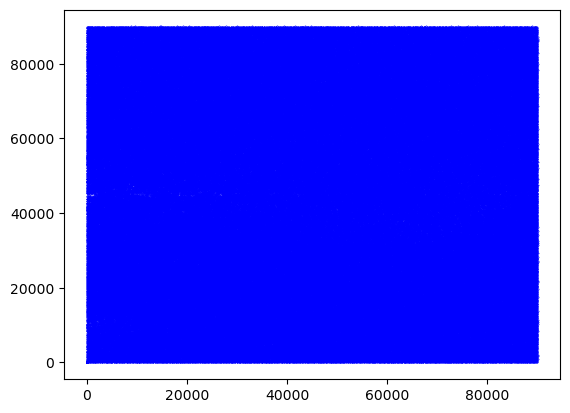

In [6]:

# nstep=10
nx = 101
ny = 101
W = 90000.0
H = 90000.0
gx = 0.0
gy = 1.3


# Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbctype = [1,-1,1,1]
# Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
Tbcval = [273.0,0.0,100.0,273.0]
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
materials = Materials()

markx = 6
marky = 6
seconds_in_year = 3.15e7
plot_interval = 1e6*seconds_in_year # plot interval in seconds
end_time = 3e7*seconds_in_year
dtmax = plot_interval
grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
println("Initial condition...")
@time initial_conditions!(markers, materials)

max_step::Int64=1000
max_time::Float64=-1.0
max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step

# Setting up inital model schematic
i_air_ice_interface = zeros(Float64,grid.nx+1)
i_ocean_ice_interface = zeros(Float64,grid.nx+1)
# Transfer materials to nodes
i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
function get_i_interface(grid::CartesianGrid,mat,contour_value)
i_interface_position = zeros(Float64,grid.nx+1);
for j in 1:grid.nx+1
    i = 1
    while i <= grid.ny
        if i_mat[i,j] == contour_value
            i_interface_position[j] = grid.yc[j]
            break
        elseif i_mat[i+1,j] < contour_value
            # interface is located within this cell.
            i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
            break
        end
        i = i+1
    end
end
return i_interface_position
end
i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)


# define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
kThermal = 3.0 .*ones(grid.ny,grid.nx);

time = 0.0
iout=0
last_plot = 0.0
dt = 1e10

rho_c = nothing
rho_vx = nothing 
rho_vy = nothing 
alpha = nothing 
Hr = nothing 
Cp_c = nothing 
eta_s = nothing 
eta_n = nothing 
vxc = nothing 
vyc = nothing 
T = nothing 
dTmax = nothing 
dTemp = nothing 
Tnew = nothing 
Tlast = nothing 

itime = 1
output_dir = "test"

terminate = false
while !terminate
    # 0. update the viscosity and the density on the markers
    update_marker_viscosity!(markers,materials)
    # 1. Transfer properties markers -> nodes
    # 1a. Basic Nodes
    eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
    # 1b. Cell Centers
    rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
    # 1c. Vx and Vy nodes:
    rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
    rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

    # deal with any NaN values from interpolation:
    if itime > 1
        if any(isnan.(eta_s_new))
            println("found nan values")
        end
        replace_nan!(eta_s,eta_s_new)
        replace_nan!(rho_c,rho_c_new)
        replace_nan!(Hr,Hr_new)
        replace_nan!(Cp_c,Cp_c_new)
        replace_nan!(alpha,alpha_new)
        replace_nan!(eta_n,eta_n_new)
        replace_nan!(Tlast,Tlast_new)
        replace_nan!(rho_vx,rho_vx_new)
        replace_nan!(rho_vy,rho_vy_new)
    end
    # Copy field data 
    rho_vx = copy(rho_vx_new)
    rho_vy = copy(rho_vy_new)
    rho_c = copy(rho_c_new)
    Hr = copy(Hr_new)
    Cp_c = copy(Cp_c_new)
    alpha = copy(alpha_new)
    eta_s = copy(eta_s_new)
    eta_n = copy(eta_n_new)
    Tlast = copy(Tlast_new)

    # 2. Assemble and solve the stokes equations
    L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
    stokes_solution = L\R
    vx,vy,P = unpack(stokes_solution,grid;ghost=true)

    # Get the velocity at the cell centers:
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
    shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s).*0.0     
    H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

    # 3. Compute the advection timestep:
    if itime > 1
        this_dtmax = min(1.2*dt,dtmax)
    else
        this_dtmax = dtmax
    end
    dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)

    dTmax = Inf
    dTemp = nothing
    Tnew = nothing
    titer = 1
    for titer=1:2
        # assemble and solve the energy equation
    #     println("Trying with timestep ",dt/3.15e7/1e6," Myr")
        println("Trying with timestep ",dt," Seconds")
        L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval);
        Tnew = L\R;
        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

        T = copy(Tnew)

        dTemp = Tnew-Tlast
        # compute the maximum temperature change
        dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))          
    #     println("dTmax=",dTmax," dt=",dt/3.15e7/1e6," Myr")
        dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
        if dTmax < 10.0
            break
        end
    end

    dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
    dT_remaining = dTemp - dT_subgrid_node

    cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

    # Checking Termination Criteria, time is in Myr
    if time >= max_time || itime >= max_step
        terminate = true
    end    

#     if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
#         last_plot = time 
#         name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#         vn = velocity_to_basic_nodes(grid,vxc,vyc)
#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#         name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#         visualization(markers,time/seconds_in_year;filename=name)
#         iout += 1
#     end
    
    if time == 0.0 || mod(itime,100) == 0
        last_plot = time 
        # Gird output
        name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
        println("Writing visualization file = ",name1)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)
        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
        # Markers output
        name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name2)
        visualization(markers,time/seconds_in_year;filename=name2)
        iout += 1
    end

    # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
    # Moving the markers and advancing to the next timestep
    move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
    time += dt
    itime += 1
    # println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    println("Finished Step ",itime," time=",time," Seconds")
end
return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

# Plotting Routine 

In [6]:
# # Setting up route for saving plots to a folder
# function mk_output_dir()
#     timestamp = Dates.format(now(), "YYYYmmdd-HHMMSS")
#     dir_name = joinpath(@__DIR__, "Data", "run_$timestamp")
#     @assert !ispath(dir_name) 
#     mkpath(dir_name)
#     return dir_name
# end

mk_output_dir (generic function with 1 method)

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 44(km)
The average initial thickness of the icy shell is 35(km)
The initial amplitude is 9.01(km)

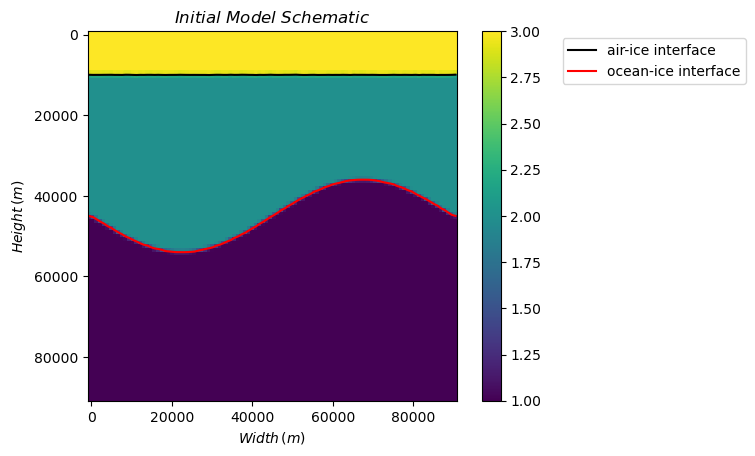

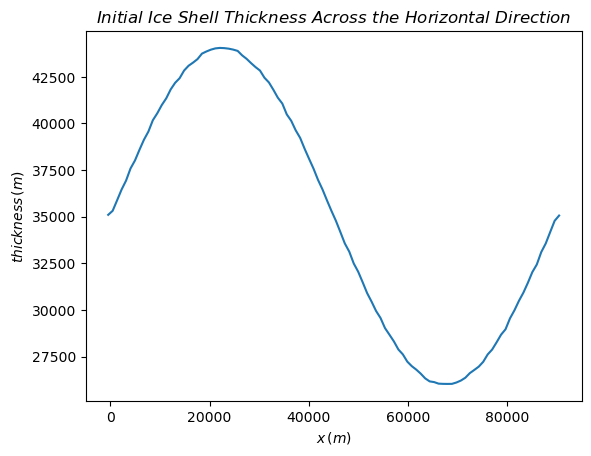

In [8]:
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
filename = "Initial Model Schematic"
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
# savefig(mk_output_dir()*"/$filename.pdf")

figure() 
plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")


println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")



# Model Schematic After x Runs 

The maximum total thickness of the icy shell after 807 Myr is 35.1(km)
The average thickness of the icy shell after 807 Myr is 35(km)
The amplitude after 807 Myr is 0.107(km)

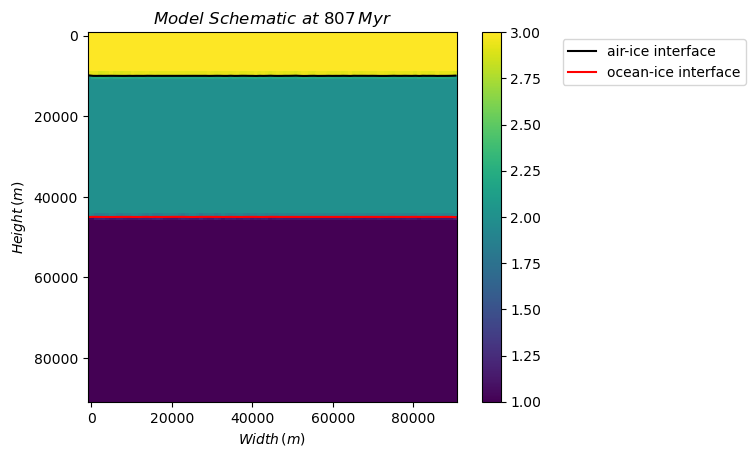

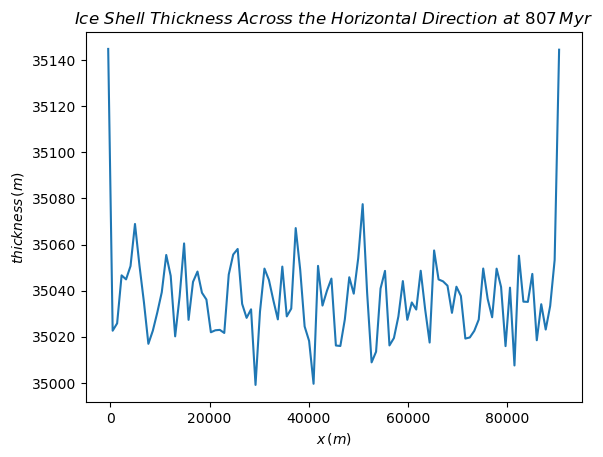

In [9]:
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
ocean_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

x_time = @sprintf("%.3g",time/3.15e7/1e6)
filename = "Model Schematic after $time"
figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

figure()
plot(grid.xc,ocean_ice_interface-air_ice_interface)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.3g",amp/1000),"(km)")

# Plot of Profiles After x Runs

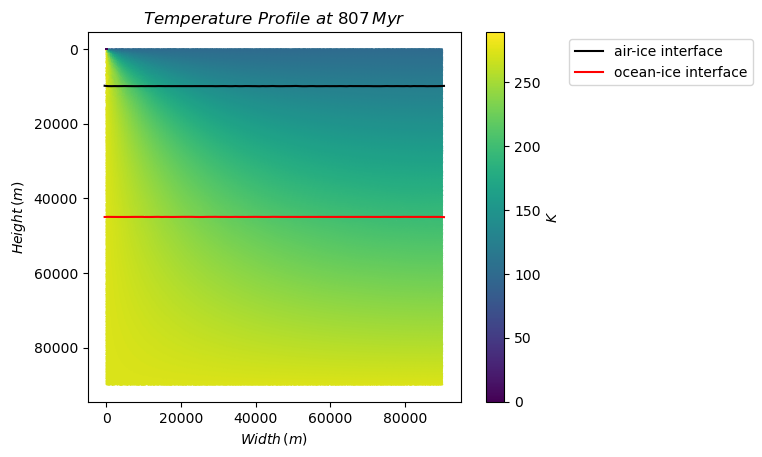

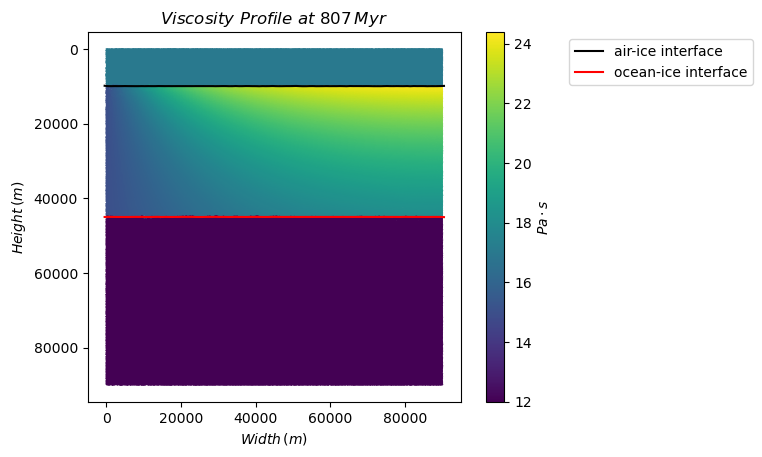

In [10]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


In [ ]:
t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")


In [ ]:
# 1. Ran numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 10km, 15km, 30km, 45km, 60km
#[experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]

# 1.
# units of Myr
exp1_x_tr1 = 0.00721
exp1_x_tr2 = 0.0267
exp1_x_tr3 = 0.0277
exp1_x_tr4 = 0.0533
exp1_x_tr5 = 0.0581
exp1_x_tr6 = 0.0715
exp1_x_tr7 = 0.0885


# units of km 
exp1_y_w1 = 10
exp1_y_w2 = 90
exp1_y_w3 = 100
exp1_y_w4 = 200
exp1_y_w5 = 300
exp1_y_w6 = 400
exp1_y_w7 = 500

figure()
plot(exp1_x_tr1,exp1_y_w1,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp1_x_tr2,exp1_y_w2,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp1_x_tr3,exp1_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp1_x_tr4,exp1_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp1_x_tr5,exp1_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp1_x_tr6,exp1_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp1_x_tr7,exp1_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,1")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


# 2. 
# units of Myr 
exp2_x_tr1 = 0.00939
exp2_x_tr2 = 0.0127
exp2_x_tr3 = 0.013
exp2_x_tr4 = 0.0195
exp2_x_tr5 = 0.0256
exp2_x_tr6 = 0.0323
exp2_x_tr7 = 0.04

# units of km 
exp2_y_w1 = 10
exp2_y_w2 = 90
exp2_y_w3 = 100
exp2_y_w4 = 200
exp2_y_w5 = 300
exp2_y_w6 = 400
exp2_y_w7 = 500

figure()
plot(exp2_x_tr1,exp2_y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp2_x_tr2,exp2_y_w2,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp2_x_tr3,exp2_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp2_x_tr4,exp2_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp2_x_tr5,exp2_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp2_x_tr6,exp2_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp2_x_tr7,exp2_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,2")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Printing Values 

In [ ]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)

40